In [3]:
import pandas as pd
import requests
import json
import re
import tqdm
import numpy as np
from multiprocessing import  Pool
from numpy import ndarray
from numpy import array
from re import fullmatch
from textblob import TextBlob
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')

2022-03-07 02:04:02 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-03-07 02:04:02 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-03-07 02:04:02 INFO: Use device: cpu
2022-03-07 02:04:02 INFO: Loading: tokenize
2022-03-07 02:04:02 INFO: Loading: pos
2022-03-07 02:04:03 INFO: Done loading processors!


In [4]:
data = pd.read_csv("dyson-mlops-assignment/pipeline-tasks/extract-preprocess-data/archive/AB_NYC_2019.csv")

In [5]:
data.shape

(48895, 16)

## How many levels does host_id have; can we use it or do we need to drop it

In [6]:
data.host_id[data.host_id.duplicated() == True].__len__() / data.host_id.__len__()

0.23392984967788116

Only 23 % of host ids are repeated; lets ignore these for now

In [7]:
data = data.drop(['id','host_id'],axis=1)

## A: Can we use host_name? maybe gender

We need to drop rows that dont have hostnames

In [8]:
data = data[~data.host_name.isna() == True].reset_index().drop(['index'], axis=1)

In [9]:
data["host_names"] = data.apply(lambda x: [name for name in re.findall("[A-Z][a-z]+", x.host_name) if name not in ["And", "and", "AND", "or", "Or", "OR"]], axis=1)

In [10]:
data = data.drop(['host_name'],axis=1)

In [11]:
data.head()

name neighbourhood_group  \
0                Clean & quiet apt home by the park            Brooklyn   
1                             Skylit Midtown Castle           Manhattan   
2               THE VILLAGE OF HARLEM....NEW YORK !           Manhattan   
3                   Cozy Entire Floor of Brownstone            Brooklyn   
4  Entire Apt: Spacious Studio/Loft by central park           Manhattan   

  neighbourhood  latitude  longitude        room_type  price  minimum_nights  \
0    Kensington  40.64749  -73.97237     Private room    149               1   
1       Midtown  40.75362  -73.98377  Entire home/apt    225               1   
2        Harlem  40.80902  -73.94190     Private room    150               3   
3  Clinton Hill  40.68514  -73.95976  Entire home/apt     89               1   
4   East Harlem  40.79851  -73.94399  Entire home/apt     80              10   

   number_of_reviews last_review  reviews_per_month  \
0                  9  2018-10-19               0.21   
1                 45  2019-05-21               0.38   
2                  0         NaN                NaN   
3                270  2019-07-05               4.64   
4                  9  2018-11-19               0.10   

   calculated_host_listings_count  availability_365       host_names  
0                               6               365           [John]  
1                               2               355       [Jennifer]  
2                               1               365      [Elisabeth]  
3                               1               194  [Lisa, Roxanne]  
4                               1                 0          [Laura]

In [12]:
from keras.models import load_model

2022-03-07 02:04:30.132629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 02:04:30.132732: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
model = load_model("dyson-mlops-assignment/tasks/docker-name-gender/assets/model/LSTMSimple")

2022-03-07 02:04:32.086665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 02:04:32.086814: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 02:04:32.086847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20220306-151656): /proc/driver/nvidia/version does not exist
2022-03-07 02:04:32.087876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
def extract(name):
    '''
    Given a string name, this function creates the sequence for LSTM
    maxlen is set to 15
    '''
    if fullmatch("[a-zA-Z]+",name):
        try:
            nameasc = ( 15 - name[:15].__len__() ) * [0] + [ord(ch) for ch in name[:15].lower()]
            nameasc = [max(el - 96,0) for el in nameasc]
            for idx in range(nameasc.__len__()):
                tmparr = [0] * 27
                tmparr[nameasc[idx]] = 1
                nameasc[idx] = tmparr
            return array([nameasc])
        except Exception as e:
            return ''.join("Error on line " + str(exc_info()[-1].tb_lineno) + " | " + str(type(e).__name__) + " | " + str(e))
    else:
        return "not supported"
    
def predict(name):
    '''
    A simple prediction endpoint
    '''
    if name:
        try:
            nparr = extract(name)
            if type(nparr) == ndarray:
                prediction = np.argmax(model.predict(nparr))
                return "M" if prediction < 1 else "F"
            else:
                return nparr
        except Exception as e:
            return ''.join("Error on line " + str(exc_info()[-1].tb_lineno) + " | " + str(type(e).__name__) + " | " + str(e))
    else:
        return "Name Needed"

In [53]:
def get_gender(val):
    if val.__len__() > 2:
        return 'E'
    elif val.__len__() < 1:
        return 'N'
    else:
        for name in val:
            if name.__len__() > 15:
                return 'E'
            else:
                if nlp(name.lower()).get('upos').pop() == "PROPN":
                    if predict(re.sub("\D\W",'',name)) == 'F':
                        return 'F'
                    else:
                        pass
                else:
                    return 'E'
        return 'NF'

## B: Mine advertisement intensity from name - extract adjectives

In [54]:
def count_adjectives(text):
    """
    Ex: Big New Family Friendly Great Location -> 0.67
    """
    try:
        doc = nlp(text).get('upos')
        return doc.count('ADJ') / doc.__len__()
    except:
        return 0

In [55]:
data.columns.tolist().index("host_names"), data.columns.tolist().index("name")

(13, 0)

In [56]:
for i in range(10):
    genders = []
    adjectives = []
    temp = data.iloc[5000*i:5000*(i+1),:]
    for val in tqdm.tqdm(temp._values):
        genders.append(get_gender(val[13]))
        adjectives.append(count_adjectives(val[0]))
    temp["genders"] = genders
    temp["adjectives"] = adjectives
    temp.to_csv(f"{i}.csv")

100%|██████████| 5000/5000 [09:18<00:00,  8.95it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 3874/3874 [07:42<00:00,  8.38it/s]


## C: Combine data

In [60]:
combined_csv = pd.concat( [ pd.read_csv(f"{val}.csv", index_col=0) for val in range(10) ] )
combined_csv.to_csv("data.csv")

## Get distance from Statue of Liberty, Central Park, Times Square, Wall Street, Empire State Bldg, Metropolitan Museum of Art, LGA, JFK, NYU & Columbia<br/>

<u><b>CHECKPOINT:</b></u> Restart kernel

In [ ]:
import os
os._exit(00)

In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
import re
import os
import time

Dropping host_names, name

In [2]:
data = pd.read_csv("data.csv", index_col=0)
data = data.drop(["host_names","name"], axis=1)

Get coordinates of landmarks

In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="airbnb_price_predictor")
location_points = {"statue of liberty":None, "central park":None, "times square":None, \
                   "wall street":None, "empire state building":None, "metropolitan museum":None, \
                   "nyu":None, "columbia university":None, "JFK":None, "LGA":None}
for key in location_points.keys():
    location = geolocator.geocode(key)
    location_points[key] = (location.latitude, location.longitude)

First create a single column of lists, then split the list column into multiple columns

In [4]:
data["distances"] = data.apply(lambda x: [np.linalg.norm(np.array((x.latitude,x.longitude)) - np.array(location_points[key])) for key in location_points.keys()], axis=1)
data[["dSoL","dCP","dTS","dWS","dESB","dMM","dNYU","dCU","dJFK","dLGA"]] = pd.DataFrame(data.distances.tolist(), index= data.index)
data.drop(["distances"], axis=1, inplace=True)

## Cleanup categories and features

<b>1. neighbourhood_group and neighbourhood are related - make into one</b>

In [5]:
data.neighbourhood_group.value_counts()

Manhattan        21652
Brooklyn         20095
Queens            5664
Bronx             1090
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [6]:
data.neighbourhood.value_counts()

Williamsburg          3919
Bedford-Stuyvesant    3714
Harlem                2656
Bushwick              2464
Upper West Side       1970
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: neighbourhood, Length: 221, dtype: int64

In [7]:
ps.sqldf(
    """
    SELECT neighbourhood, COUNT(DISTINCT neighbourhood_group)
    FROM data
    GROUP BY neighbourhood
    HAVING COUNT(DISTINCT neighbourhood_group) > 1
    """
)

Empty DataFrame
Columns: [neighbourhood, COUNT(DISTINCT neighbourhood_group)]
Index: []

This creates too many levels<br/>
Sub using lat-long for neighborhood

In [8]:
location_points = {n_r:None for n_r in data.neighbourhood.value_counts().index.tolist()}

In [9]:
for key in location_points.keys():
    if location_points[key] is None:
        try:
            time.sleep(1)
            location = geolocator.geocode(key)
            if re.match(".*new.*york,.*",location.address.lower()):
                location_points[key] = (location.latitude, location.longitude)
            else:
                time.sleep(1)
                location = geolocator.geocode(key+",New York")
                if re.match(".*new.*york,.*",location.address.lower()):
                    location_points[key] = (location.latitude, location.longitude)
                else:
                    print(f"{location_points[key]} not found")
        except:
            print(f"{location_points[key]} not found")
    else:
        pass

None not found
None not found


Manually fill in missing keys

In [10]:
[key for key in location_points.keys() if location_points[key] is None]

['Pelham Gardens', 'East Morrisania']

In [11]:
location_points["Pelham Gardens"] = (40.8619444, -73.86)
location_points["Highbridge"] = (40.84591775, -73.92984478686536)
location_points["Randall Manor"] = (40.637997448, -74.101999592)
location_points["East Morrisania"] = (40.8233792, -73.9110322)

In [12]:
[key for key in location_points.keys() if location_points[key] is None], location_points.__len__()

([], 221)

In [13]:
data["N_gr"] = data.apply(lambda x: location_points[x.neighbourhood], axis=1)
data[["n_r_lat", "n_r_long"]] = pd.DataFrame(data.N_gr.tolist(), index= data.index)
data.drop(["N_gr"], axis=1, inplace=True)

In [14]:
data.head(3)

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    149               1                  9  2018-10-19               0.21   
1    225               1                 45  2019-05-21               0.38   
2    150               3                  0         NaN                NaN   

   ...       dTS       dWS      dESB       dMM      dNYU       dCU      dJFK  \
0  ...  0.110616  0.071896  0.101809  0.130709  0.085180  0.160624  0.193050   
1  ...  0.004213  0.053688  0.005523  0.031507  0.027379  0.058481  0.232436   
2  ...  0.067890  0.122974  0.074738  0.037989  0.096525  0.019790  0.232368   

       dLGA    n_r_lat   n_r_long  
0  0.161999  40.793434 -73.722076  
1  0.112595  40.760085 -73.978159  
2  0.076200  40.807879 -73.945415  

[3 rows x 26 columns]

In [17]:
data.drop(["neighbourhood", "latitude", "longitude"], axis=1, inplace=True)
data.head(3)

neighbourhood_group        room_type  price  minimum_nights  \
0            Brooklyn     Private room    149               1   
1           Manhattan  Entire home/apt    225               1   
2           Manhattan     Private room    150               3   

   number_of_reviews last_review  reviews_per_month  \
0                  9  2018-10-19               0.21   
1                 45  2019-05-21               0.38   
2                  0         NaN                NaN   

   calculated_host_listings_count  availability_365 genders  ...       dTS  \
0                               6               365      NF  ...  0.110616   
1                               2               355       F  ...  0.004213   
2                               1               365       F  ...  0.067890   

        dWS      dESB       dMM      dNYU       dCU      dJFK      dLGA  \
0  0.071896  0.101809  0.130709  0.085180  0.160624  0.193050  0.161999   
1  0.053688  0.005523  0.031507  0.027379  0.058481  0.232436  0.112595   
2  0.122974  0.074738  0.037989  0.096525  0.019790  0.232368  0.076200   

     n_r_lat   n_r_long  
0  40.793434 -73.722076  
1  40.760085 -73.978159  
2  40.807879 -73.945415  

[3 rows x 23 columns]

In [18]:
data.to_csv("data_2.csv")

<b>CHECKPOINT:</b>

In [ ]:
import os
os._exit(00)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
data = pd.read_csv("data_2.csv", index_col=0)
data.head(3)

neighbourhood_group        room_type  price  minimum_nights  \
0            Brooklyn     Private room    149               1   
1           Manhattan  Entire home/apt    225               1   
2           Manhattan     Private room    150               3   

   number_of_reviews last_review  reviews_per_month  \
0                  9  2018-10-19               0.21   
1                 45  2019-05-21               0.38   
2                  0         NaN                NaN   

   calculated_host_listings_count  availability_365 genders  ...       dTS  \
0                               6               365      NF  ...  0.110616   
1                               2               355       F  ...  0.004213   
2                               1               365       F  ...  0.067890   

        dWS      dESB       dMM      dNYU       dCU      dJFK      dLGA  \
0  0.071896  0.101809  0.130709  0.085180  0.160624  0.193050  0.161999   
1  0.053688  0.005523  0.031507  0.027379  0.058481  0.232436  0.112595   
2  0.122974  0.074738  0.037989  0.096525  0.019790  0.232368  0.076200   

     n_r_lat   n_r_long  
0  40.793434 -73.722076  
1  40.760085 -73.978159  
2  40.807879 -73.945415  

[3 rows x 23 columns]

Get a list of null/na valued columns

In [3]:
data.columns[data.isnull().any() | data.isnull().any()].tolist()

['last_review', 'reviews_per_month']

Are the columns related? Yes

In [4]:
data[( data.last_review.isnull() | data.last_review.isna() ) &\
     ~( data.reviews_per_month.isnull() | data.reviews_per_month.isna() )]

Empty DataFrame
Columns: [neighbourhood_group, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365, genders, adjectives, dSoL, dCP, dTS, dWS, dESB, dMM, dNYU, dCU, dJFK, dLGA, n_r_lat, n_r_long]
Index: []

[0 rows x 23 columns]

In [5]:
data[( data.last_review.isnull() | data.last_review.isna() )].__len__() / data.__len__()

0.20556942341531284

So ~ 10000 rows have these as missing

<u>Tactic 1: Lets impute missing reviews_per_month with 0 and drop last review column</u>

In [6]:
data.drop(['last_review'], axis=1, inplace=True)
data.reviews_per_month.replace(np.nan,0, inplace=True)

In [7]:
data.columns[data.isnull().any() | data.isnull().any()].tolist()

[]

In [8]:
data.head(3)

neighbourhood_group        room_type  price  minimum_nights  \
0            Brooklyn     Private room    149               1   
1           Manhattan  Entire home/apt    225               1   
2           Manhattan     Private room    150               3   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                  9               0.21                               6   
1                 45               0.38                               2   
2                  0               0.00                               1   

   availability_365 genders  adjectives  ...       dTS       dWS      dESB  \
0               365      NF       0.375  ...  0.110616  0.071896  0.101809   
1               355       F       0.000  ...  0.004213  0.053688  0.005523   
2               365       F       0.125  ...  0.067890  0.122974  0.074738   

        dMM      dNYU       dCU      dJFK      dLGA    n_r_lat   n_r_long  
0  0.130709  0.085180  0.160624  0.193050  0.161999  40.793434 -73.722076  
1  0.031507  0.027379  0.058481  0.232436  0.112595  40.760085 -73.978159  
2  0.037989  0.096525  0.019790  0.232368  0.076200  40.807879 -73.945415  

[3 rows x 22 columns]

In [9]:
X, y = data.drop(['price'],axis=1), data.price

In [10]:
numerics = X.select_dtypes(include=np.number).columns.tolist()
categoricals = [col for col in X.columns if col not in numerics]

In [11]:
min_max_scl = MinMaxScaler()
X_n = min_max_scl.fit_transform(X[numerics])

In [12]:
one_hot_enc = OneHotEncoder()
X_c = one_hot_enc.fit_transform(X[categoricals])

In [13]:
X = pd.concat([pd.DataFrame(X_c.toarray(), columns=[val for cat in one_hot_enc.categories_ for val in cat.tolist()], dtype=int),\
 pd.DataFrame(X_n, columns=numerics)], axis=1)

## Lets check distribution of Y

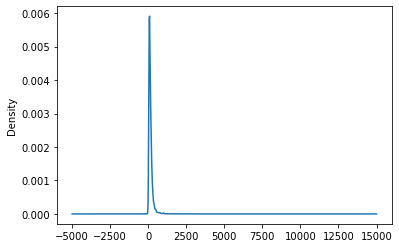

In [14]:
y.plot.density()
plt.show()

The distribution is clearly skewed toward lower rent amounts; we might need to transform the data

In [15]:
log_y = pd.Series(np.log10(y)).replace(-np.inf, 0)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


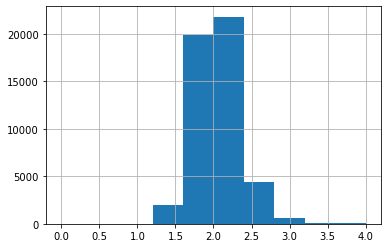

In [16]:
log_y.hist()
plt.show()

This looks normalized

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.25, random_state=42)

rfr = RandomForestRegressor(random_state=42, n_jobs=8)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_jobs=8, random_state=42)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rfr.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.03552886892778483 0.6066471284760016


In [21]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 8,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
from sklearn.linear_model import LinearRegression

lgr = LinearRegression()
lgr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lgr.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.0424954576078742 0.5295175224756062


In [24]:
from xgboost import XGBRegressor

xgr = XGBRegressor(random_state=42, n_jobs=8)
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
y_pred = xgr.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.03612174378342465 0.6000831979609516


In [101]:
from sklearn.svm import LinearSVR

lsr = LinearSVR(max_iter=100000)
lsr.fit(X_train, y_train)

LinearSVR(max_iter=100000)

In [102]:
y_pred = lsr.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.042722539953433246 0.527003412249367


In [103]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

SVR()

In [104]:
y_pred = svr.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.03982907335973324 0.5590380203761848


In [106]:
X_train.to_csv("Datasets/train_X.csv")
X_test.to_csv("Datasets/test_X.csv")
y_train.to_csv("Datasets/train_y.csv")
y_test.to_csv("Datasets/test_y.csv")

<b>CHECKPOINT:</b>

In [ ]:
import os
os._exit(00)

In [30]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from optuna.study import create_study
from IPython.display import clear_output

In [31]:
X_train, X_test, y_train, y_test = (pd.read_csv("Datasets/train_X.csv", index_col=0),\
                                    pd.read_csv("Datasets/test_X.csv", index_col=0),\
                                    pd.read_csv("Datasets/train_y.csv", index_col=0),\
                                    pd.read_csv("Datasets/test_y.csv", index_col=0))

In [53]:
def objective(trial):
    n_estimators =  trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    regr = RandomForestRegressor(bootstrap = True, criterion="squared_error",
                                 verbose=1, n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=42, n_jobs=8)
    
    regr.fit(X_train, np.ravel(y_train))
    
    return r2_score(y_true=np.ravel(y_test), y_pred=regr.predict(X_test))

In [54]:
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-03-09 03:05:30,813] A new study created in memory with name: no-name-332701cd-0053-4959-8398-506f15efa143
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:   36.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 189 out of 189 | elapsed:    0.3s finished
[I 2022-03-09 03:06:07,522] Trial 0 finished with value: 0.6100201175252538 and parameters: {'n_estimators': 189, 'max_depth': 21, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 0 with value: 0.6100201175252538.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 228 out 

In [55]:
study.best_params

{'n_estimators': 318,
 'max_depth': 97,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

In [59]:
rfr_final = RandomForestRegressor(
    n_estimators=318,
    max_depth=97,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=8
)

In [60]:
rfr_final.fit(X_train, np.ravel(y_train))

RandomForestRegressor(max_depth=97, max_features='sqrt', n_estimators=318,
                      n_jobs=8, random_state=42)

In [61]:
y_pred = rfr_final.predict(X_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred), r2_score(y_pred=y_pred, y_true=y_test))

0.03511468084120406 0.6112327535781891


In [62]:
import json
with open("params.json", "w") as file:
    json.dump(study.best_params, file)

In [66]:
from pickle import dump
with open("one_hot_enc.pkl", "wb") as file:
    dump(one_hot_enc, file)
with open("min_max_scl.pkl", "wb") as file:
    dump(min_max_scl, file)

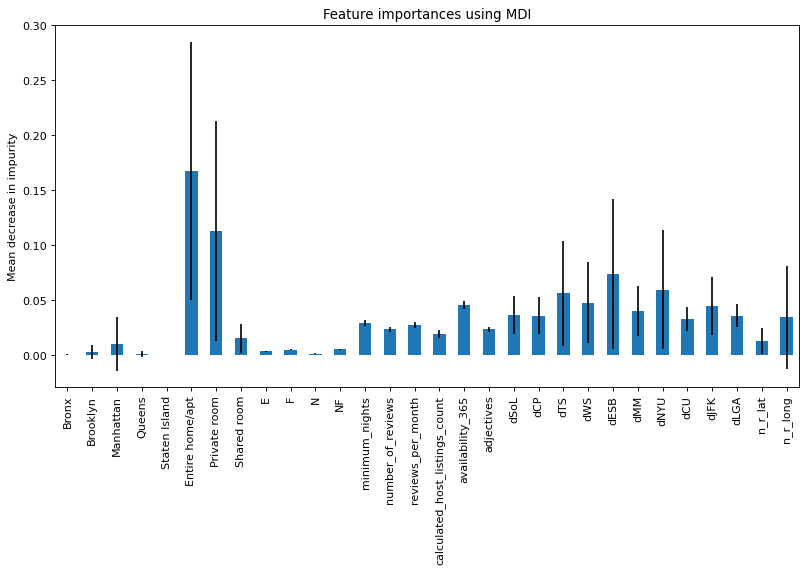

In [76]:
feature_names = X_train.columns.tolist()
forest_importances = pd.Series(rfr_final.feature_importances_, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfr_final.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.show()

## Some Talking points

<br/>0. <b>Tried Approaches:</b> Sentiment mining, NER based gender extract<br/>1. <b>Geo-features:</b> 3km radius buffer to get #schools, #marts, #hospitals -> latent correlate with property value<br/>2. <b>Deep Learning:</b> Use conv2d(map) + sequential(room_type, min_nights, number_0f_reviews, reviews_per_month, calculated_host_listings_count, availability_365, adjectives)